# Ocena jakości wina Vinho Verde

Celem zadania jest ocena jakości wina.

Uwzględniono dwa zbiory danych dotyczące próbek czerwonego wina Vinho Verde z północy Portugalii.

Źródło: 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

- 1600 obserwacji z 11 zmiennymi wejściowymi i jedną zmienną wyjściową.
- Zmienne opisują:
  1. Stałą kwasowość.
  2. Kwasowość lotną.
  3. Kwas cytrynowy.
  4. Cukier resztkowy.
  5. Chlorki.
  6. Wolny dwutlenek siarki.
  7. Całkowity dwutlenek siarki.
  8. Gęstość.
  9. pH.
  10. Siarczany.
  11. Alkohol.
  12. Jakość (ocena od 0 do 10).

[Dane](https://github.com/UEPP40/PUM/blob/c1ab27e52bc82cc151bb217b27bd25dfd057d9e8/winequality-red.csv)


( ͡° ͜ʖ ͡°) I really don't know much about wine


# Import bibliotek, pliku csv oraz wstępny przegląd danych

In [36]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import hashlib as hl
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [37]:
# Wczytanie danych z pliku CSV do ramki danych
wineDataFrame = pd.read_csv('winequality-red.csv', sep=";")

# Wyświetlenie pierwszych 5 rekordów wraz z podstawowymi informacjami o danych
print("Pierwsze 5 rekordów zbioru danych:")
print(wineDataFrame.head())

print("\nInformacje o zbiorze danych:")
# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())

print("\nStatystyki opisowe zbioru danych:")
# Wyświetlenie statystyk opisowych zbioru danych
print(wineDataFrame.describe())


Pierwsze 5 rekordów zbioru danych:
   fixed acidity  volatile acidity citric acid residual sugar chlorides  \
0            7.4              0.70           0            1.9     0.076   
1            7.8              0.88           0            2.6     0.098   
2            7.8              0.76        0.04            2.3     0.092   
3           11.2              0.28        0.56            1.9     0.075   
4            7.4              0.70           0            1.9     0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2  

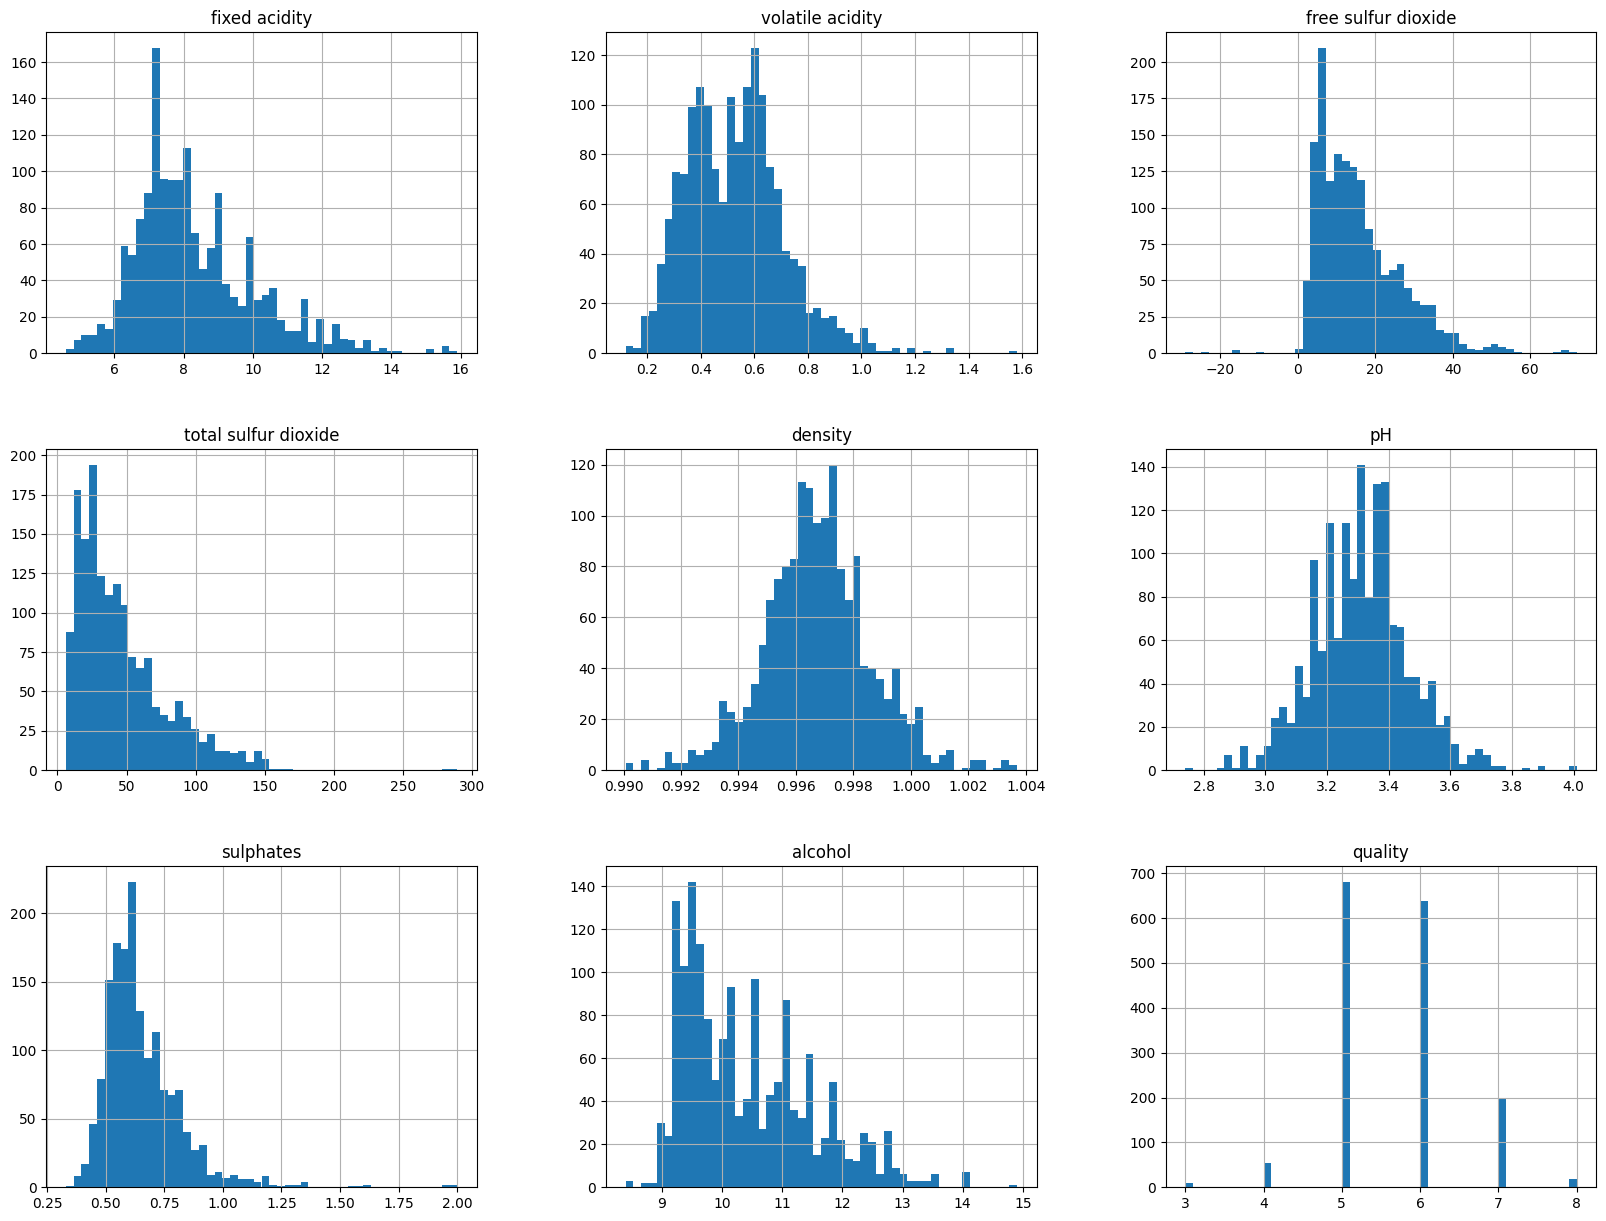

In [38]:
# Narysowanie histogramów dla wszystkich zmiennych oraz kilku innych przydatnych wykresów
wineDataFrame.hist(bins=50, figsize=(20,15))
plt.show()

# Czyszczenie danych

In [39]:
# !Technicznie dane bakujące można by było uzupełnić statystycznie ale powinno być na tyle dużo danych że można bez problemu je wywalić
# Usuń wiersze z duplikatami
wineDataFrame.drop_duplicates(inplace=True)
# Usuń wiersze z brakującymi danymi
wineDataFrame.dropna(inplace=True)
# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())
print(wineDataFrame.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   object 
 3   residual sugar        1359 non-null   object 
 4   chlorides             1359 non-null   object 
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 138.0+ KB
None
(1359, 12)


In [40]:
# usuń zbędne znaki (nie będące Ascii)
for column in wineDataFrame.columns:
    wineDataFrame[column] = wineDataFrame[column].astype(str).str.replace(r'[^\x00-\x7F]+', '', regex=True)
# zmien typ zmiennych ilościowych
for column in wineDataFrame.columns:
    wineDataFrame[column] = pd.to_numeric(wineDataFrame[column], errors='coerce')
# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1356 non-null   float64
 3   residual sugar        1358 non-null   float64
 4   chlorides             1356 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB
None


In [41]:
# print empty values
print(wineDataFrame.isnull().sum())
# uzupełnij braki średnią
for column in wineDataFrame.columns:
    if wineDataFrame[column].isnull().sum() > 0:
        wineDataFrame[column] = wineDataFrame[column].fillna(method='pad')

fixed acidity           0
volatile acidity        0
citric acid             3
residual sugar          1
chlorides               3
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


C:\Users\marci\AppData\Local\Temp\ipykernel_12840\1190288140.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wineDataFrame[column] = wineDataFrame[column].fillna(method='pad')


In [42]:
# drop kicknij kolumny ze znacznie odstającymi wartościami (pomiń kolumnę "quality")
for column in wineDataFrame.columns:
    if column != 'quality' and pd.api.types.is_numeric_dtype(wineDataFrame[column]):
        Q1 = wineDataFrame[column].quantile(0.10)
        Q3 = wineDataFrame[column].quantile(0.90)
        IQR = Q3 - Q1

        filter = (wineDataFrame[column] >= Q1 - 1.5 * IQR) & (wineDataFrame[column] <= Q3 + 1.5 * IQR)
        wineDataFrame = wineDataFrame.loc[filter]

<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1278 non-null   float64
 1   volatile acidity      1278 non-null   float64
 2   citric acid           1278 non-null   float64
 3   residual sugar        1278 non-null   float64
 4   chlorides             1278 non-null   float64
 5   free sulfur dioxide   1278 non-null   float64
 6   total sulfur dioxide  1278 non-null   float64
 7   density               1278 non-null   float64
 8   pH                    1278 non-null   float64
 9   sulphates             1278 non-null   float64
 10  alcohol               1278 non-null   float64
 11  quality               1278 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 129.8 KB
None


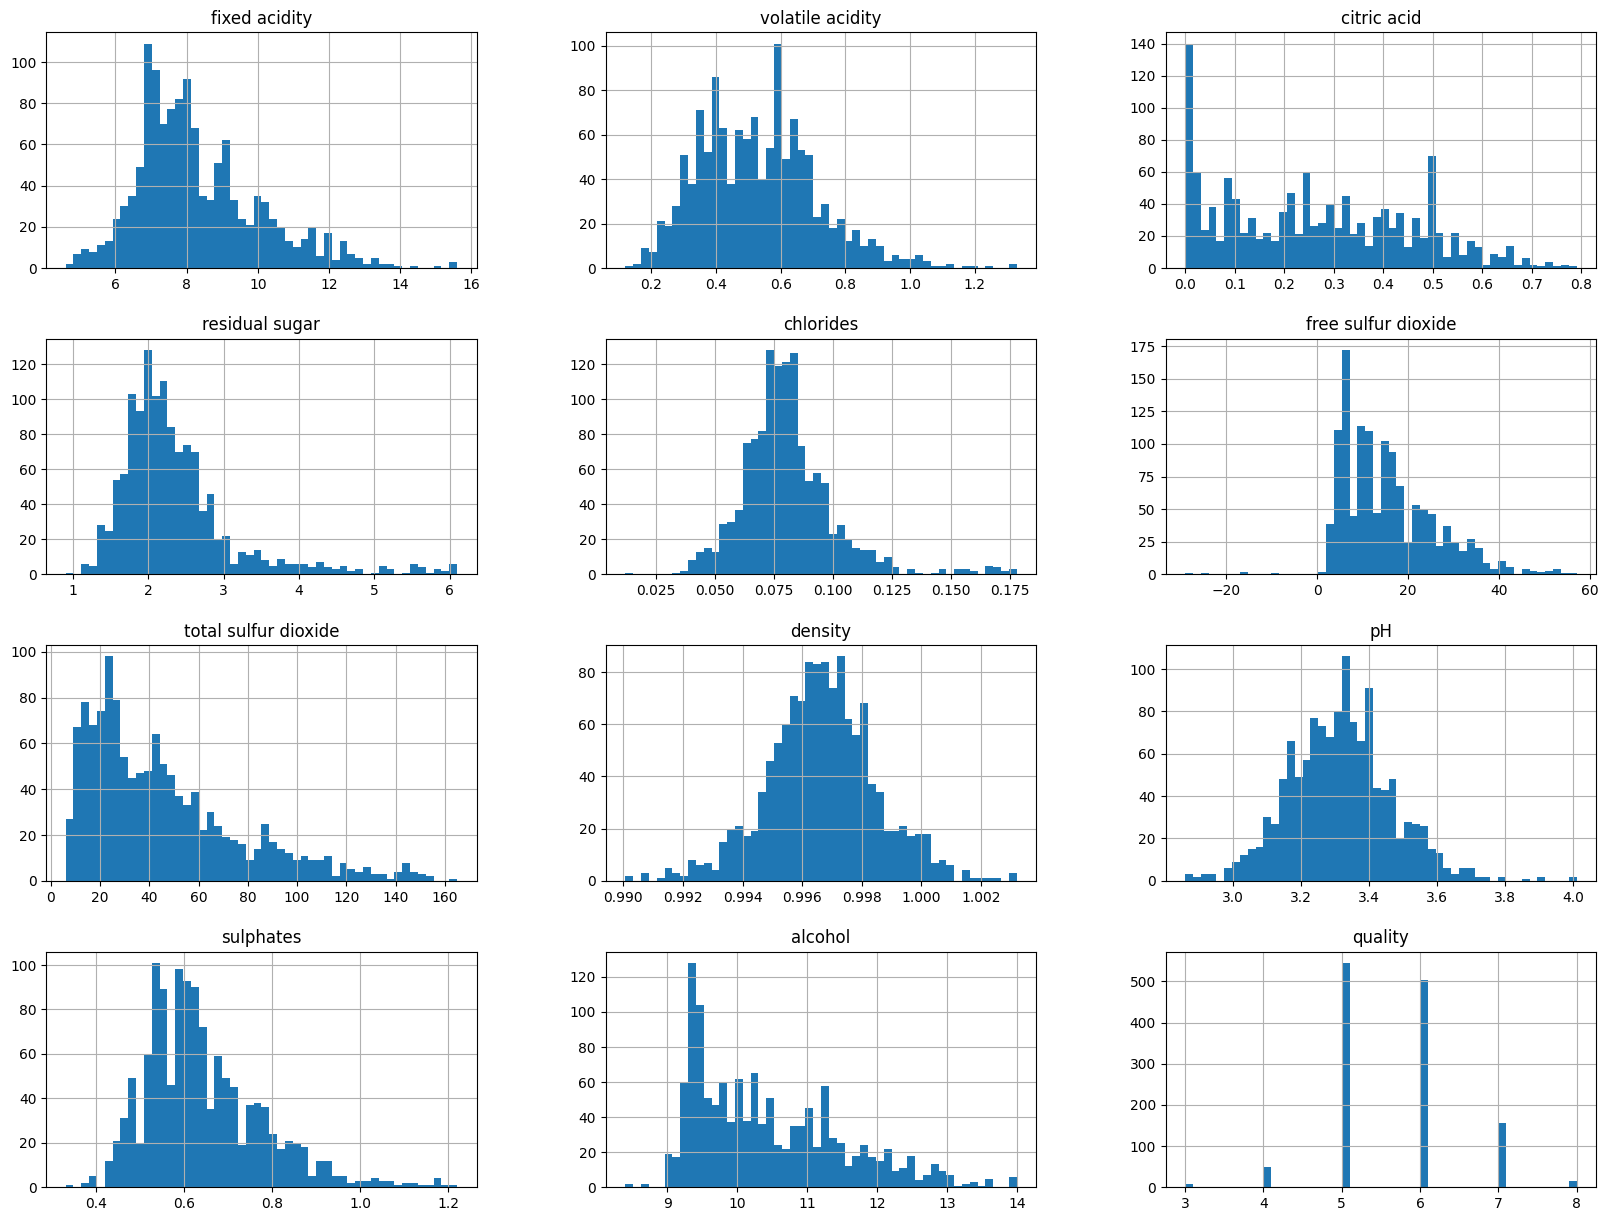

In [43]:
print(wineDataFrame.info())
# plot histogram
wineDataFrame.hist(bins=50, figsize=(20,15))
plt.show()


In [44]:
# stwórz obiekt enkodera
le = LabelEncoder()
for column in wineDataFrame.columns:
    if pd.api.types.is_object_dtype(wineDataFrame[column]):
        wineDataFrame[column] = le.fit_transform(wineDataFrame[column])
# sprawdź transformacje
wineDataFrame.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


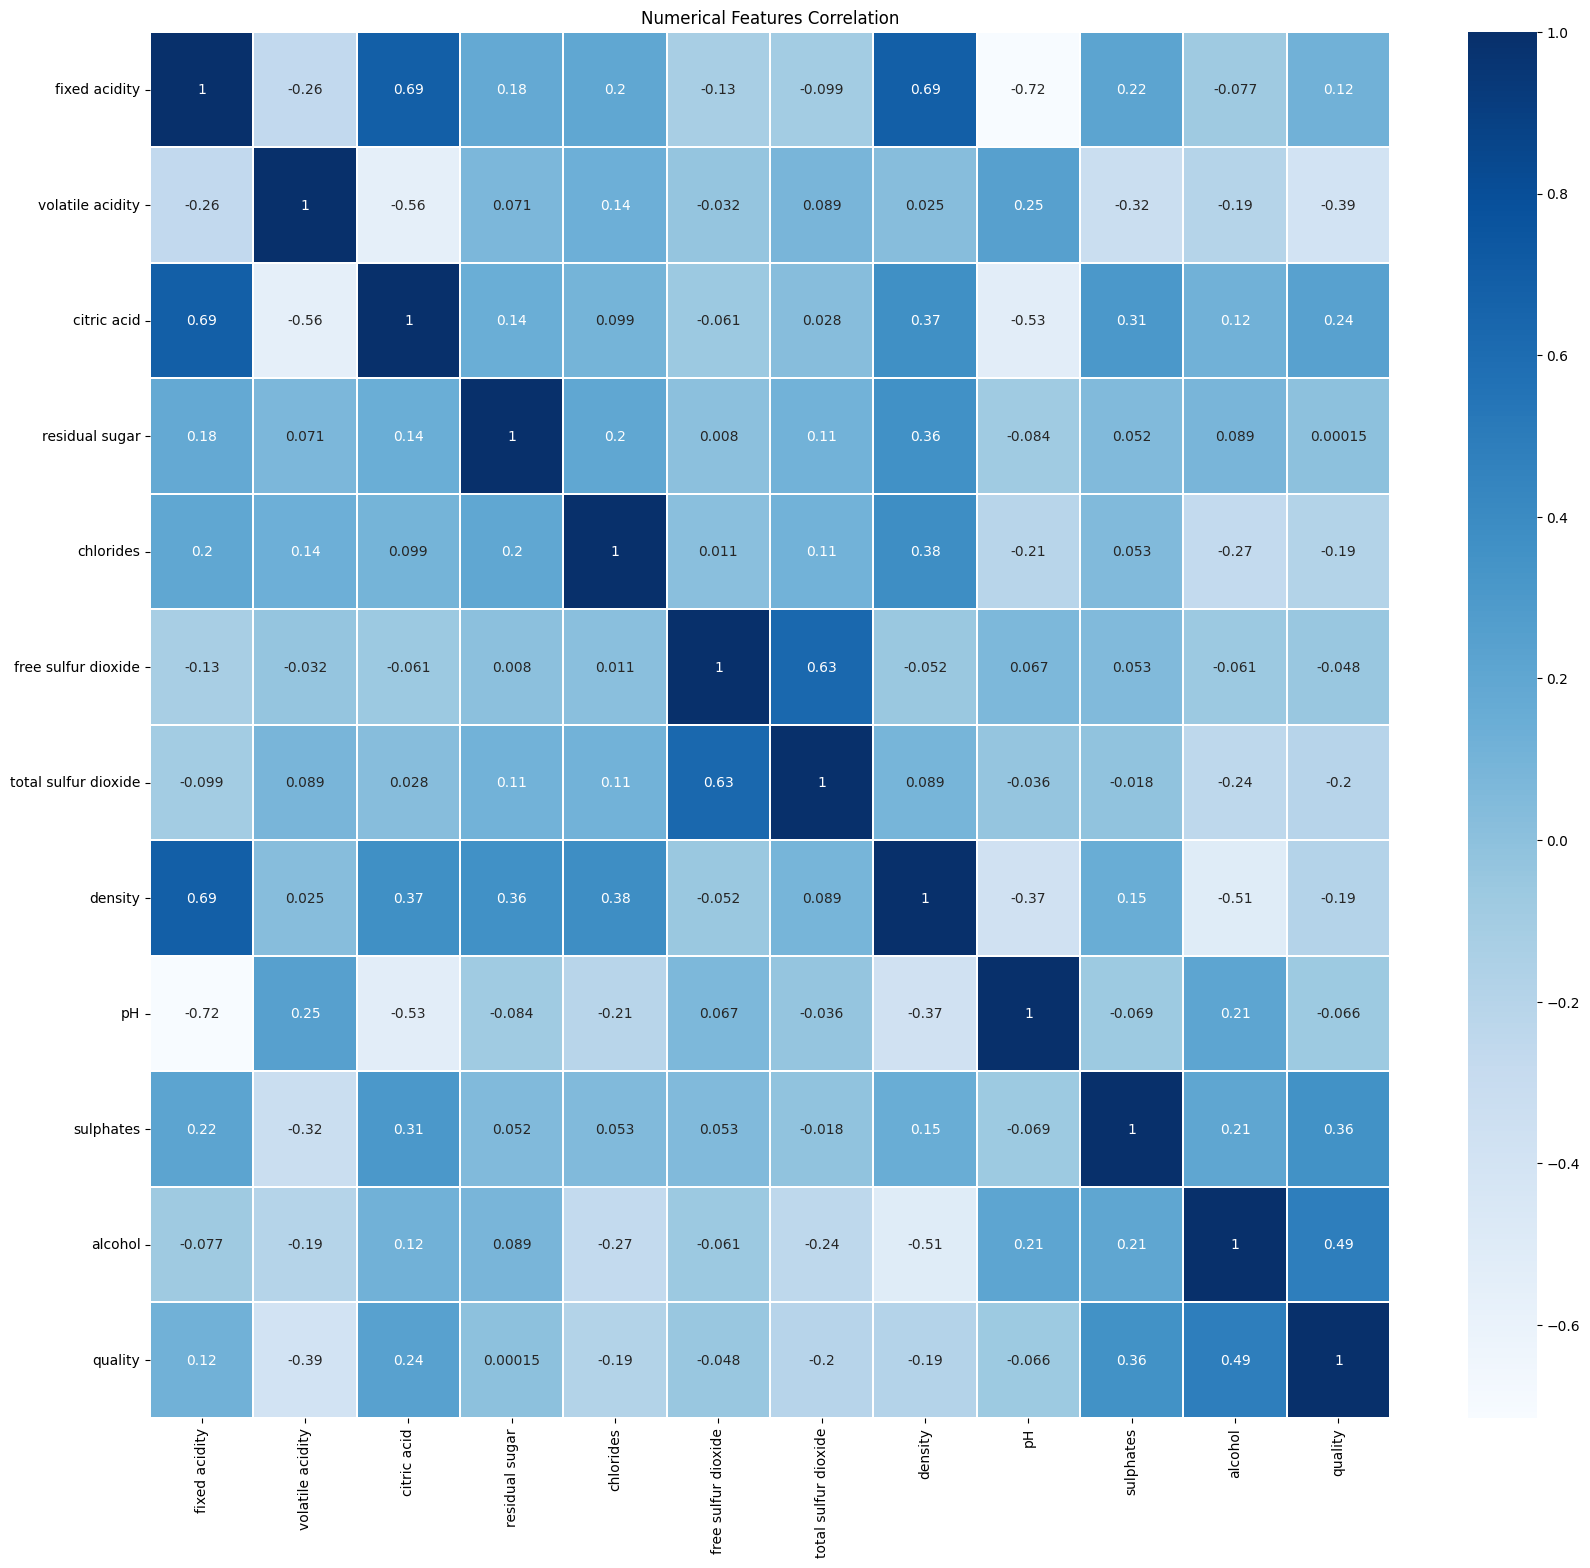

In [45]:
# wskaż korelacje
plt.figure(figsize = (20, 18)) 
# creating the correlation heatmap
sns.heatmap(wineDataFrame.corr(), annot = True, linewidths = 0.1, cmap = 'Blues')
plt.title('Numerical Features Correlation')
plt.show()

In [46]:
corr_matrix = wineDataFrame.corr()
cor_target = abs(corr_matrix["quality"])
relevant_features = cor_target[cor_target>0.01]
wineDataFrame = wineDataFrame[relevant_features.index]

# print which features are relevant
print("Relevant features (correlation with 'quality' > 0.01):\n", relevant_features)

# and which are not
print("\nNon-relevant features (correlation with 'quality' <= 0.01):\n", cor_target[cor_target<=0.01])

Relevant features (correlation with 'quality' > 0.01):
 fixed acidity           0.120039
volatile acidity        0.388788
citric acid             0.237149
chlorides               0.185173
free sulfur dioxide     0.048290
total sulfur dioxide    0.204902
density                 0.190666
pH                      0.065677
sulphates               0.356120
alcohol                 0.488122
quality                 1.000000
Name: quality, dtype: float64

Non-relevant features (correlation with 'quality' <= 0.01):
 residual sugar    0.000152
Name: quality, dtype: float64


❌❌❌ ***PCA DO NOT UNCOMMENT IF YOU DO NOT KNOW WHAT ARE YOU DOING (I DON'T TBH)*** ❌❌❌

In [47]:
# # Zastosuj transformację PCA (Principal Component Analysis) do danych
# pca = PCA(n_components=10)
# filtered_pca_df = pca.fit(wineDataFrame)
# print(pca.explained_variance_ratio_)
# print(filtered_pca_df.components_)

# # Wypisz dataframe po zastosowaniu PCA oraz wyjaśnij jakie zmienne są najważniejsze
# filtered_pca_df = pca.transform(wineDataFrame)
# filtered_pca_df = pd.DataFrame(filtered_pca_df, columns=["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6", "PCA7", "PCA8", "PCA9", "PCA10"])
# print(filtered_pca_df)

# Podział danych na zbiory treningowe i testowe

In [28]:
# Zrobiłem to tylko po to by w kodzi pojawiło się słowo 'Amongus'

string_to_int = lambda s: int(hl.md5(s.encode()).hexdigest(), 16) % 4294967295

# Podziel dane na zbiór uczący i testowy
X = wineDataFrame.drop(columns=["quality"])
y = wineDataFrame["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=string_to_int("Amongus"))

In [49]:
# Display the data splits
print("Training data (features):")
print(X_train.head())
print("\nTest data (features):")
print(X_test.head())
print("\nTraining data (target):")
print(y_train.head())
print("\nTest data (target):")
print(y_test.head())

Training data (features):
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
323            10.3             0.590         0.42             2.8      0.090   
735             7.7             0.965         0.10             2.1      0.112   
757             8.1             0.870         0.00             2.2      0.084   
1376            8.2             0.885         0.20             1.4      0.086   
863             7.2             0.620         0.06             2.5      0.078   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
323                  35.0                  73.0  0.99900  3.28       0.70   
735                  11.0                  22.0  0.99630  3.26       0.50   
757                  10.0                  31.0  0.99656  3.25       0.50   
1376                  7.0                  31.0  0.99460  3.11       0.46   
863                  17.0                  84.0  0.99746  3.51       0.53   

      alcohol  
323     